# Pset 6
Yining Hua

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1. the beginner's game
Since I've learned stats and programming in undergrad school, I'll not spend time explaining everything in great detail. They seem straightforward to me and I don't benefit from repeating everything again. That is to say, for question descriptions this week (full of laTex), visit the [course page](http://mcb112.org/w06/w06-homework.html) (I hope it doesn't change over years).

Alright! let's take a look at the game script!

In [2]:
!python student-game.py 3

Welcome to Student's game night...

The RNG seed is 1828

The hidden grid has 20 rows for sigma 100.0..5.0,
                and 21 cols for mu -100.0..100.0.

Student picked grid col = 15, row = 8
and thus mu = 50.0, sigma = 60.0

Student's tea distribution machine shows the customers 3 samples:
     93.67
     39.79
     58.35

which give sample mean:    63.94
   and sample std.dev.:    27.37
Figure(640x480)


That Figure object
at end of the stdout is a nice little distribution figure. Below is an exmaple (not in the same round as the one above).
![figure(640x640)](gameoutput_3.png)

### Play the beginner's game?

In [225]:
import subprocess
import os
import re

def play(n):
    process = os.popen("python student-game.py "+str(n))
    result = process.read()
    mu = float(re.search(r'mu = (.*?), sigma', result).group(1))
    sigma = float(re.search(r'sigma = (.*?)\n', result).group(1))
    samples = [float(i.strip()) for i in result.split("\n") if 
               i.replace("-","").replace(".","").strip().isnumeric()]
    return samples, sigma, mu

play(3)


([-59.67, 80.37, -13.69], 65.0, -70.0)

In [328]:
from scipy import stats
from scipy.special import logsumexp
def beginner_post_p(Xs, sigma, mus):
    """Guess we did this in the last pset 
    """
    probs = [sum([stats.norm.logpdf(x, mu, sigma) for x in Xs]) for mu in mus]
    return np.exp([p - logsumexp(probs) for p in probs])   ## yes this is our posterior p

In [329]:
def beginner_pub_p(Xs, sigma, mus):
    """Just some equations following the lecture note
    """
    probs = [stats.norm.logpdf(mu, np.mean(Xs), sigma/np.sqrt(len(Xs))) for mu in mus]   ## see the difference than postp?
    return np.exp([p - logsumexp(probs) for p in probs])   ## and yes this is pub's p 

In [330]:
def analyze_example(Xs, true_sigma, true_mu, mus):
    post_ps = (beginner_post_p(Xs, true_sigma, mus))
    pub_ps = (beginner_pub_p(Xs, true_sigma, mus))
        
    fig, axs = plt.subplots(1, figsize=(12,8))
    axs.semilogy(mus, post_ps, color="pink", linewidth=6)
    axs.semilogy(mus, pub_ps, color="blue", linestyle ="-.", linewidth=0.8)
    axs.axvline(x=true_mu, color="k", linestyle="dashed", alpha=0.5)
    axs.label_outer()
        
    plt.title("Probability Estimate Curve")
    plt.legend(["Post P","Pub P","True $\mu$"]) 
    plt.xlabel("$\mu$", ha="center")
    plt.ylabel("$P(\mu|\sigma,x)$")

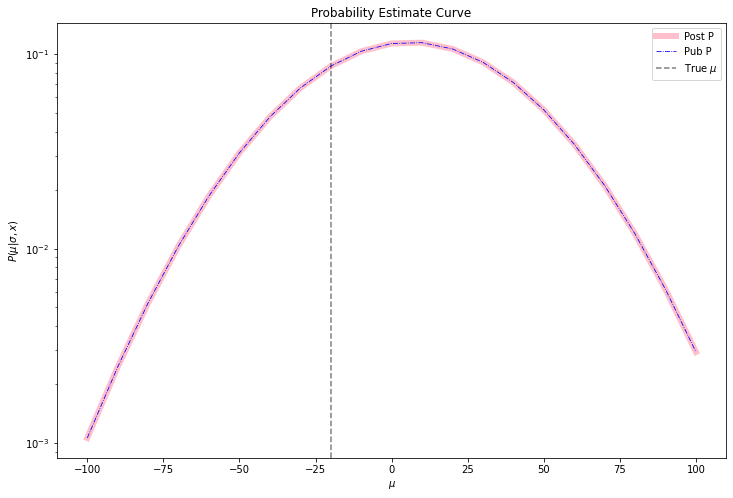

In [331]:
Xs         = np.array([ 11.50, -2.32, 9.18]) # n=3 observations
true_sigma = 60.                             # Student also tells you this in beginner's game
true_mu    = -20.                            # the unknown column position, mu
mus        = np.arange(-100,110,10)          # our x axis, the list of mus

analyze_example(Xs, true_sigma, true_mu, mus)

So yea, like the question said, "all three samples just happened to come out to the right of the true μ, by chance, and fairly tightly grouped."

The following two chunks are just for playing around. It runs the game multiple times and plots the results\
Not needed in the assignment 


In [241]:
def hit_to_go(n, true_sigma, true_mu, mus, iterations):
    true_mus, true_sigmas, samples, post_ps, pub_ps = [], [], [], [], []
    for i in range(iterations):
        Xs, sigma, mu = play(n)
        true_mus.append(mu)
        true_sigmas.append(sigma)
        samples.append(Xs)
        post_ps.append(beginner_post_p(Xs, sigma, mus))
        pub_ps.append(beginner_pub_p(samples, sigma, mus))
        
    fig, axs = plt.subplots(iterations,figsize=(6,4*iterations))
 
    for plt_idx, ax in enumerate(axs):
        ax.semilogy(mus, post_ps[plt_idx], color="pink")
        ax.semilogy(mus, pub_ps[plt_idx], color="gray", alpha=0.6)
        ax.axvline(x=true_mus[plt_idx],color="k", linestyle="dashed", alpha=0.5)
        ax.label_outer()
    plt.legend(["Bayesian","Pub","True $\mu$"]) 
    plt.xlabel("$\mu$")
    plt.ylabel("$P(\mu|\sigma,x)$")
    return samples, true_mus, true_sigmas

([[65.46, 62.22, 105.59], [8.65, 8.33, -39.11], [6.5, -22.76, -51.29]],
 [60.0, 40.0, -50.0],
 [70.0, 50.0, 35.0])

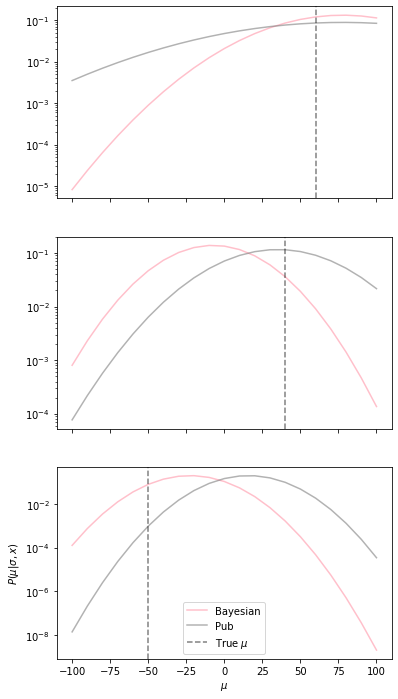

In [242]:
true_sigma = 60.                             # Student also tells you this in beginner's game
true_mu    = -20.                            # the unknown column position, mu
mus        = np.arange(-100,110,10)         
hit_to_go(3, true_sigma, true_mu, mus, iterations=3)

## 2. the advanced game
We are no longer told what the true sigma is but no worries my laptop gets it let's use some brutal force 

In [322]:
def advanced_post_p(Xs, sigmas, mus):
    """post probability's now a #sigmas by #mus matrix. Exciting """
    posts = np.zeros((len(sigmas), len(mus)))
    for i in range(len(sigmas)):
        for j in range(len(mus)):
            posts[i,j] = sum([stats.norm.logpdf(x,mus[j],sigmas[i]) for x in Xs])
            
    posts = posts - logsumexp(posts)   ## division a log scale
    post_p_margins = np.exp(logsumexp(posts, axis=0)) # mariginalization along sigmas
    posts = np.exp(posts)
    
    return posts, post_p_margins


In [323]:
def advanced_pub_p(Xs, mus):
    """ Notice the way the pub' calculating the Ps is different -> np.std(Xs, ddof=1)"""
    probs = [stats.norm.logpdf(mu, np.mean(Xs), np.std(Xs, ddof=1)/np.sqrt(len(Xs))) for mu in mus]
    pub_ps = np.exp([p - logsumexp(probs) for p in probs])
    return pub_ps

In [324]:
def probdist_t(X, mu_values):
    """ 
    Copied from the pset prompt. Not my code obviously
    -------------------
    Given an ndarray X_1..X_n,
    and a list of the mu values in each column;
    return a list of the inferred P(mu | X) for each column,
    according to Student's t distribution with N-1 degrees of freedom.
    """
    N    = len(X)
    xbar = np.mean(X)
    s    = np.std(X, ddof=1)
    t    = [ (xbar - mu) / (s / np.sqrt(N)) for mu in mu_values ]    # t statistic, given sample mean, sample stddev, and N
#   t    = [ stats.ttest_1samp(X, mu)[0] for mu in mu_values ]       # ... (equivalently, python can calculate t statistic for you)
    Pr   = [ stats.t.pdf(val, N-1) for val in t ]
    Z    = sum(Pr)
    Pr   = [ p / Z for p in Pr ]    
    return Pr

In [332]:
def analyze_example_advanced(Xs, true_mu, true_sigma, mus, sigmas):
    post_ps, post_p_margins = advanced_post_p(Xs, sigmas, mus)
    pub_ps = advanced_pub_p(Xs, mus)
    t_ps = probdist_t(Xs, mus)
     
    ## --- They really should‘ve writen a one-liner plot package. plt.sem.tile.legend.x.y(xxx). Che bella! ----
    plt.figure(figsize=(10,6))
    plt.semilogy(mus, post_p_margins, color="pink", linewidth=4)
    plt.semilogy(mus, pub_ps, color="gray", alpha=0.6,linewidth=2)
    plt.semilogy(mus, t_ps, color="k", linestyle="-.", linewidth=2, alpha=0.8)
    plt.axvline(x=true_mu, color="blue", linestyle="dashed", alpha=0.5)
    plt.title("Probability Estimate Curve")
    plt.legend(["Marginalized post P","Pub P","T-Dist P","True $\mu$", "True $\sigma$"], loc="lower right") 
    plt.xlabel("$\mu$")
    plt.ylabel("$P(\mu|x)$")
    
    plt.figure(figsize=(10.5,8))
    ax = sns.heatmap(post_ps, xticklabels = mus, yticklabels = sigmas) 
    ax.invert_yaxis()
    plt.title("Probability Heatmap")
    plt.xlabel('$\mu$')
    plt.ylabel("$\sigma$")

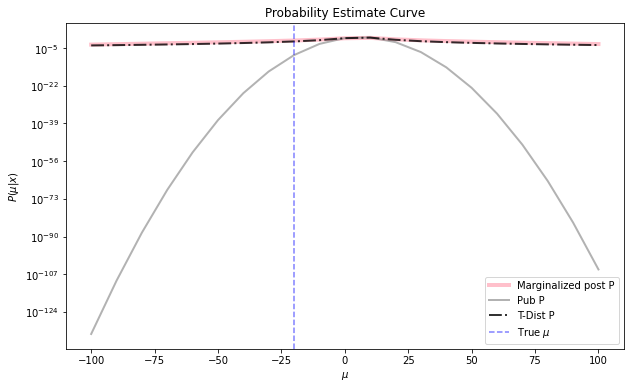

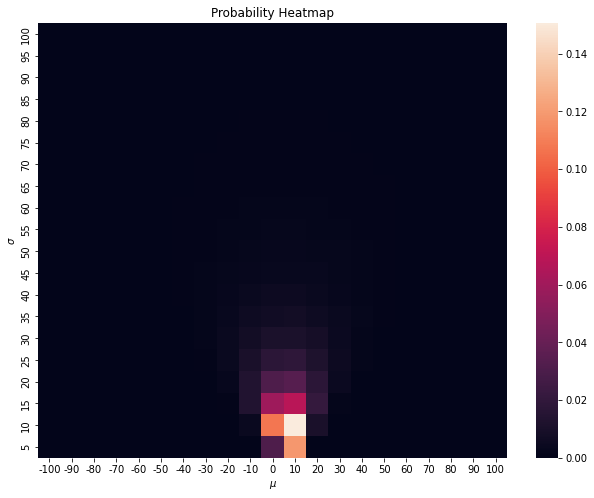

In [333]:
Xs = [ 11.50, -2.32, 9.18]    ## to be easily checked
mus = np.arange(-100,110,10)  
sigmas = np.arange(5,105,5) 

analyze_example_advanced(Xs, true_mu, true_sigma, mus, sigmas)

## where's the advantage?
Is the pub calculating its odds correctly? Where do you see an advantage?

### Answer
I guess you've probably found out that the pub's probility pattern's different from those of the posterior probability and the t-distribution probability (and the later two are quite the same). Let's try some other samples  

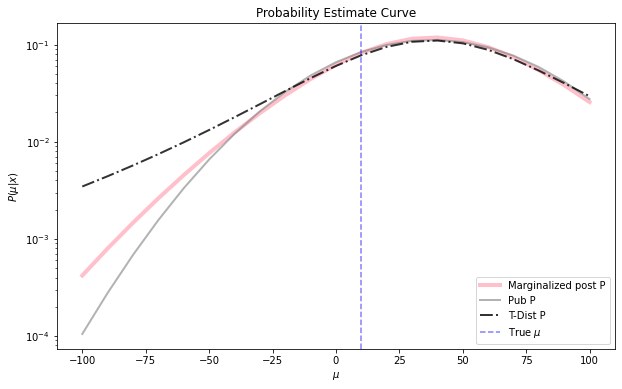

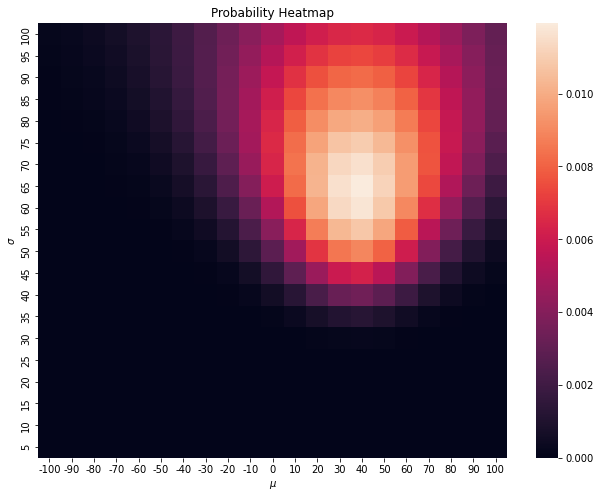

In [334]:
Xs, true_sigma, true_mu = play(4)
analyze_example_advanced(Xs, true_mu, true_sigma, mus, sigmas)


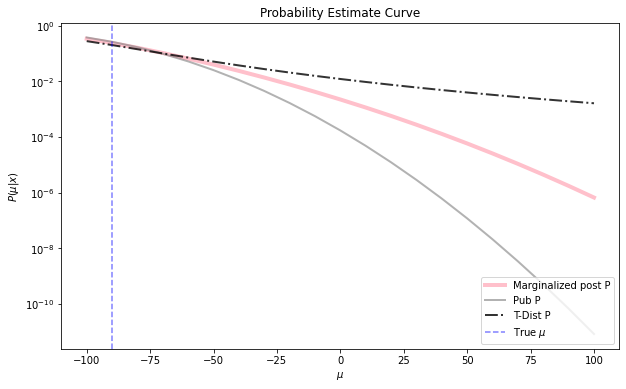

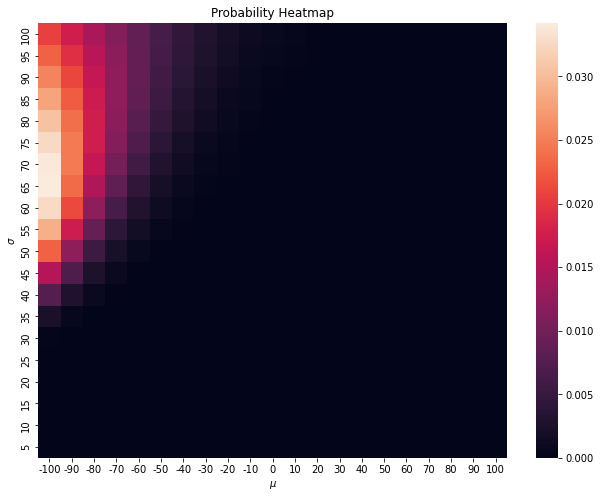

In [337]:
Xs, true_sigma, true_mu = play(4)
analyze_example_advanced(Xs, true_mu, true_sigma, mus, sigmas)


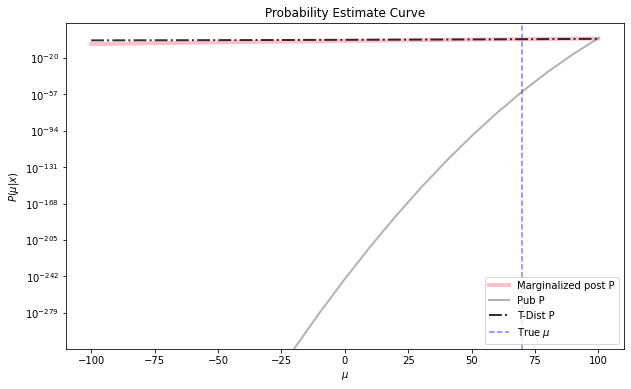

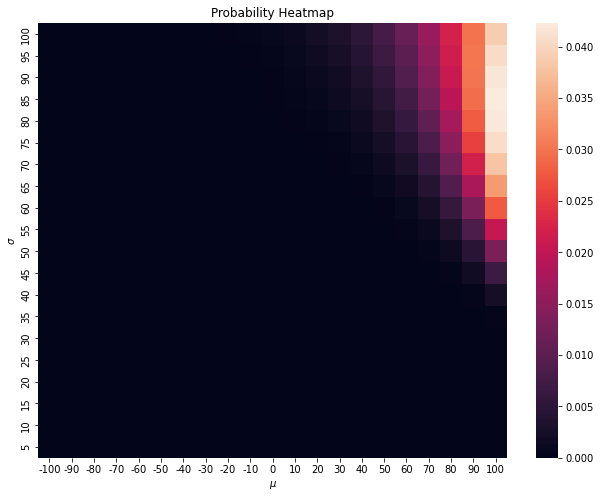

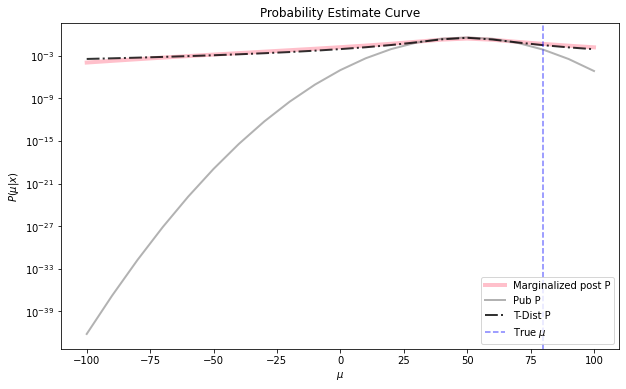

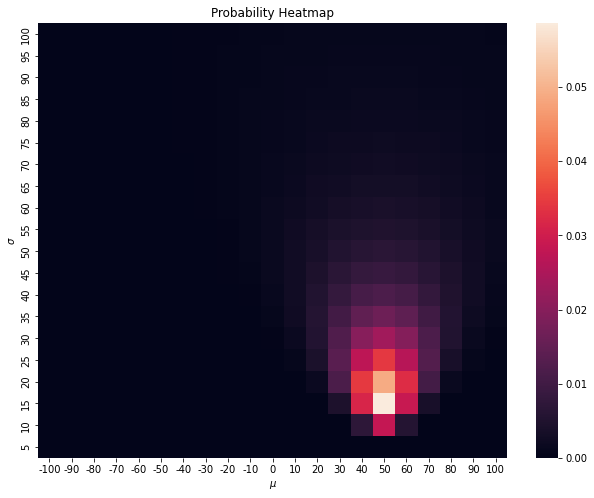

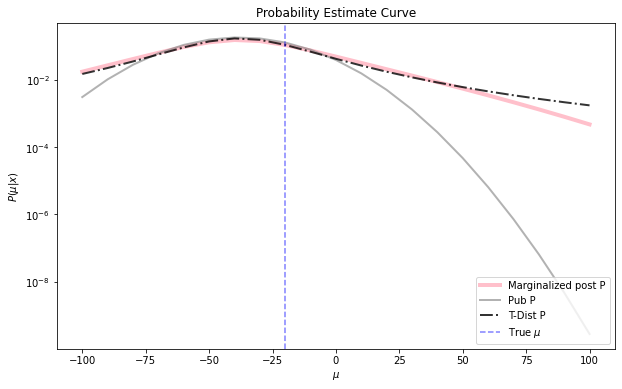

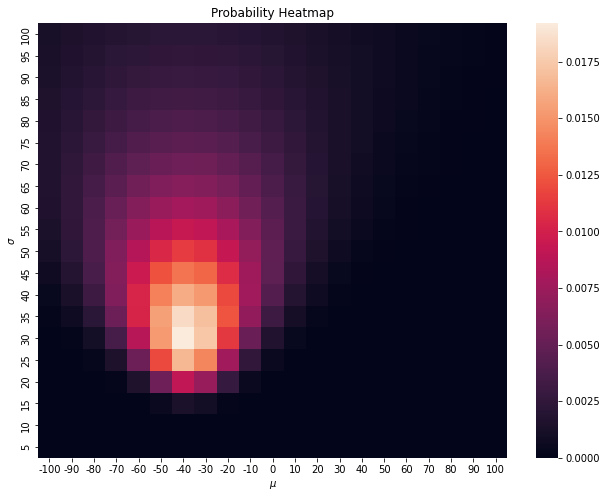

In [336]:
for iteration in range(3):
    Xs, true_sigma, true_mu = play(3)
    analyze_example_advanced(Xs, true_mu, true_sigma, mus, sigmas)


We can see from the previous results of (the pub's probability distribution + Bayesian posterior probability distribution + the T-distribution) that pub's P is usually high near where the tea bags were dropped, and low (exponential decays observed, showing an overall bell or half-bell shaped distribution) at other places. The further the place is to the place where the bags were actually dropped, the lower the probabilities calculated by the pub are. This whole trend differs from the marginalized posterior probability distribution (and also what we got from T-distributions). So we'd say the pub's way of calculating the probability is somehow wrong - The "fair odds" Student offers are not fair at all. Recall the difference I cautioned about between ```advanced_pub_p()``` and ```advanced_post_p()```, the pub uses ```np.std(Xs, ddof=1)/np.sqrt(len(Xs)``` which is more prone to the extreme influences brought to $\sigma$ by small sample sizes.
According to the hint in this homework:
- "if you can identify situations where your expected winnings are positive (where Student has underestimated the probability), you can exploit that".

since such situations happen at tails of the distributions (far end of where the bags were dropped), I'd say that our advantage is that for all places we have more equal chance to win (at least greater chance than what's estimated by the pub, especially in the tail cases). But still, the chance is still too low to be something I'd call a real advantage. 
